In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import random

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

from PIL import Image

#SALVAMENTO DOS ARQUIVOS
import pathlib
import urllib.request
import tarfile

In [5]:
# Obtém o diretório onde o notebook está salvo
notebook_dir = pathlib.Path().resolve()

# Define o caminho desejado para salvar os dados
data_dir = notebook_dir / "flower_photos"

# URL do dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

# Caminho do arquivo .tgz que será baixado
tgz_path = notebook_dir / "flower_photos.tgz"

# Faz o download manualmente caso o arquivo não exista
if not tgz_path.exists():
    print("Baixando o dataset...")
    urllib.request.urlretrieve(dataset_url, tgz_path)

# Extrai os arquivos diretamente para o local correto
if not data_dir.exists():
    print("Extraindo os arquivos...")
    with tarfile.open(tgz_path, "r:gz") as tar:
        tar.extractall(path=notebook_dir)

# Remove o arquivo .tgz após a extração (opcional)
tgz_path.unlink()

print(f"Dados salvos em: {data_dir}")


Baixando o dataset...
Dados salvos em: C:\Users\kenny\OneDrive\Documentos\UFPB\P7\Processamento Digital de Imagens\TrabalhoPDI\flower_photos


In [7]:
#cópia do conjunto de dados disponível. Há 3.670 imagens no total:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


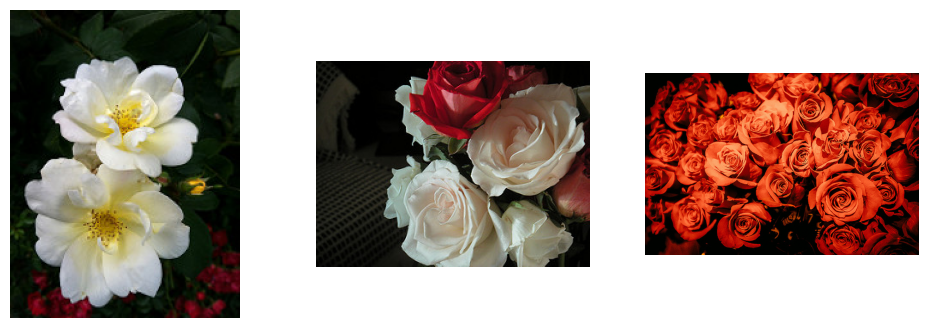

In [9]:
#Impressão de Rosa:

# Seleciona as três primeiras imagens da pasta "roses"
roses = list(data_dir.glob('roses/*'))
images = [PIL.Image.open(str(roses[i])) for i in range(3)]

# Cria uma figura com três subplots lado a lado
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Exibe cada imagem em um subplot
for ax, img in zip(axes, images):
    ax.imshow(img)
    ax.axis("off")  # Remove os eixos

plt.show()

# Carregar os dados - utilitário Keras

### Criar um conjunto de Dados

In [13]:
batch_size = 64 #define quantas imagens serão processadas de uma vez durante o treinamento ou a inferência do modelo.
img_height = 180
img_width = 180

### Divisão para Treinamento

In [16]:
#80% das imagens para treinamento
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


### Divisão para Validação

In [19]:
# Verifique o código onde o val_ds é criado
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [21]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# Visualização dos Dados

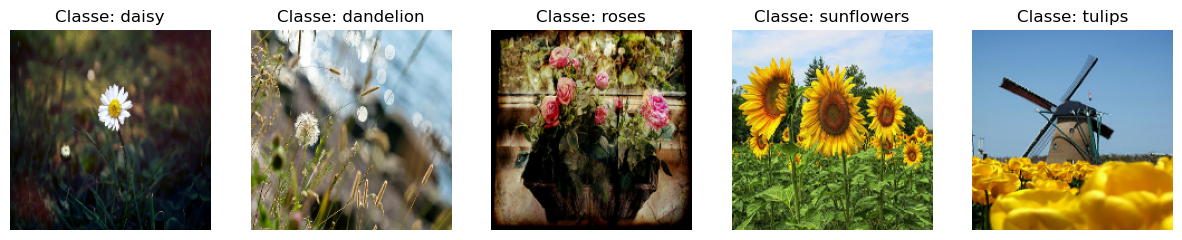

In [24]:

# Inicializando a figura
plt.figure(figsize=(15, 5))

# Criar um iterador para o dataset
image_batch, label_batch = next(iter(train_ds))

# Iterar pelas 5 classes
for i in range(5):
    # Pegar a primeira imagem de cada classe
    idx = np.where(label_batch.numpy() == i)[0][0]  # Pegamos o índice da primeira ocorrência da classe
    image = image_batch[idx]

    # Redimensionar a imagem para exibição
    resized_image = tf.image.resize(image, [img_height, img_width]).numpy().astype("uint8")

    # Plotar a imagem
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(resized_image)
    plt.title(f"Classe: {class_names[i]}")
    plt.axis("off")

# Mostrar as imagens
plt.show()

In [26]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 180, 180, 3)
(64,)


# Configurar o conjunto de dados para desempenho

In [29]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) #mantém as imagens na memória depois de serem carregadas fora do disco durante a primeira época
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) #sobrepõe o pré-processamento de dados e a execução do modelo durante o treinamento.

# Padronização dos Dados

In [32]:
#Os valores do canal RGB estão na faixa [0, 255] . Isso não é ideal para uma rede neural; em geral, você deve procurar tornar seus valores de entrada pequenos.
normalization_layer = layers.Rescaling(1./255)

# Aplicar normalização ao pipeline de treinamento e validação
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Verificação do Pipeline de Dados

In [35]:
# Verificar o pipeline de dados normalizado
for images, labels in normalized_train_ds.take(1):
    print("Formato das imagens (treinamento normalizado):", images.shape)
    print("Valores mínimos e máximos (treinamento normalizado):", tf.reduce_min(images).numpy(), tf.reduce_max(images).numpy())
print(" ")
for images, labels in normalized_val_ds.take(1):
    print("Formato das imagens (validação normalizada):", images.shape)
    print("Valores mínimos e máximos (validação normalizada):", tf.reduce_min(images).numpy(), tf.reduce_max(images).numpy())
print(" ")
for images, labels in normalized_train_ds.take(1):
    print("Rótulos:", labels.numpy())

Formato das imagens (treinamento normalizado): (64, 180, 180, 3)
Valores mínimos e máximos (treinamento normalizado): 0.0 1.0
 
Formato das imagens (validação normalizada): (64, 180, 180, 3)
Valores mínimos e máximos (validação normalizada): 0.0 1.0
 
Rótulos: [3 0 1 4 4 0 3 1 3 3 1 2 0 3 1 3 1 1 4 4 4 3 1 2 2 0 3 2 2 2 3 3 4 3 1 0 0
 1 0 4 3 3 4 3 3 4 2 1 0 1 0 2 3 1 4 1 1 3 1 1 4 2 4 1]


In [36]:
# #Os valores do canal RGB estão na faixa [0, 255] . Isso não é ideal para uma rede neural; em geral, você deve procurar tornar seus valores de entrada pequenos.
# normalization_layer = layers.Rescaling(1./255)

# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

# Balanceamento *

In [38]:
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# Criação do Modelo

In [40]:
num_classes = len(class_names)

model = Sequential([
  layers.Input(shape=(img_height, img_width, 3)), # Inserindo Input Shape separado do Rescaling
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes),
  layers.Dropout(0.2)

])

# Compilação do Modelo

In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
# # Compilação do modelo c/ one-hot encoding (não utilizado)
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# Resumo do Modelo

In [51]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

# Treinamento

In [54]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 346ms/step - accuracy: 0.2654 - loss: 1.8557 - val_accuracy: 0.4646 - val_loss: 1.3345
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 326ms/step - accuracy: 0.4484 - loss: 1.3182 - val_accuracy: 0.5913 - val_loss: 1.0537
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 315ms/step - accuracy: 0.5332 - loss: 1.1288 - val_accuracy: 0.6131 - val_loss: 0.9787
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 306ms/step - accuracy: 0.5901 - loss: 0.9998 - val_accuracy: 0.6294 - val_loss: 0.9367
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 310ms/step - accuracy: 0.6436 - loss: 0.9099 - val_accuracy: 0.6485 - val_loss: 0.9178
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 310ms/step - accuracy: 0.6863 - loss: 0.7686 - val_accuracy: 0.6676 - val_loss: 0.8720
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 313ms/step - accuracy: 0.7316 - loss: 0.6727 - val_accuracy: 0.6199 - val_loss: 1.0015
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 315ms/step - accuracy: 0.7663 - loss: 0.5623 - val_accu

In [56]:
# Avaliação do modelo no conjunto de teste

train_accuracy = history.history['accuracy'][-1]

# Imprimir a acurácia do treinamento
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

Training Accuracy: 86.24%


# Visualização dos Dados do Treino

In [59]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

In [61]:
####### EMITE O CLASSIFICATION REPORT DO VAL_DS, mas do TRAIN_DS sai semrpe incorreto


# Supondo que você já tenha o modelo treinado e os datasets carregados

# 1. Fazer previsões no conjunto de teste
probabilities = model.predict(val_ds)  # Use val_ds ou test_ds, dependendo do seu caso
predictions = np.argmax(probabilities, axis=1)

# 2. Extrair os rótulos reais do conjunto de teste
y_true = np.concatenate([y for x, y in val_ds], axis=0)  # Use val_ds ou test_ds

# 3. Gerar o classification report
print(classification_report(y_true, predictions, target_names=class_names))

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step
              precision    recall  f1-score   support

       daisy       0.62      0.58      0.60       129
   dandelion       0.73      0.69      0.71       176
       roses       0.47      0.48      0.48       120
  sunflowers       0.86      0.71      0.78       152
      tulips       0.54      0.69      0.60       157

    accuracy                           0.64       734
   macro avg       0.65      0.63      0.63       734
weighted avg       0.66      0.64      0.64       734



In [62]:
# Supondo que você já tenha o modelo treinado e os datasets carregados

# 1. Fazer previsões no conjunto de teste
probabilities = model.predict(val_ds)  # Use val_ds ou test_ds, dependendo do seu caso
predictions = np.argmax(probabilities, axis=1)

# 2. Extrair os rótulos reais do conjunto de teste
y_true = np.concatenate([y for x, y in val_ds], axis=0)  # Use val_ds ou test_ds

# 3. Gerar o classification report
print(classification_report(y_true, predictions, target_names=class_names))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
              precision    recall  f1-score   support

       daisy       0.62      0.58      0.60       129
   dandelion       0.73      0.69      0.71       176
       roses       0.47      0.48      0.48       120
  sunflowers       0.86      0.71      0.78       152
      tulips       0.54      0.69      0.60       157

    accuracy                           0.64       734
   macro avg       0.65      0.63      0.63       734
weighted avg       0.66      0.64      0.64       734



# Etapa 2

In [66]:
# Cria as pastas adicionais
treinamento_flip_dir = notebook_dir / "treinamento_flip"
treinamento_rotate_dir = notebook_dir / "treinamento_rotate"
treinamento_zoom_dir = notebook_dir / "treinamento_zoom"

# Verifica se as pastas já existem, caso contrário, cria
treinamento_flip_dir.mkdir(exist_ok=True)
treinamento_rotate_dir.mkdir(exist_ok=True)
treinamento_zoom_dir.mkdir(exist_ok=True)

print(f"Pasta 'treinamento_flip' criada em: {treinamento_flip_dir}")
print(f"Pasta 'treinamento_rotate' criada em: {treinamento_rotate_dir}")
print(f"Pasta 'treinamento_zoom' criada em: {treinamento_zoom_dir}")

Pasta 'treinamento_flip' criada em: C:\Users\kenny\OneDrive\Documentos\UFPB\P7\Processamento Digital de Imagens\TrabalhoPDI\treinamento_flip
Pasta 'treinamento_rotate' criada em: C:\Users\kenny\OneDrive\Documentos\UFPB\P7\Processamento Digital de Imagens\TrabalhoPDI\treinamento_rotate
Pasta 'treinamento_zoom' criada em: C:\Users\kenny\OneDrive\Documentos\UFPB\P7\Processamento Digital de Imagens\TrabalhoPDI\treinamento_zoom


# Função de Treinamento

In [68]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers

def train_model(data_dir, img_height=180, img_width=180, batch_size=64, epochs=10):
    """
    Função para treinar um modelo de aprendizado de máquina com um conjunto de imagens.

    Parâmetros:
    - data_dir: Caminho do diretório contendo as imagens.
    - img_height: Altura das imagens redimensionadas (padrão: 180).
    - img_width: Largura das imagens redimensionadas (padrão: 180).
    - batch_size: Número de imagens processadas por lote (padrão: 64).
    - epochs: Número de épocas de treinamento (padrão: 10).

    Retorna:
    - history: Histórico de treinamento contendo métricas de acurácia e perda.
    - train_accuracy: Acurácia final do treinamento.
    """
    # Cria os datasets de treinamento e validação
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )

    # Obtém os nomes das classes
    class_names = train_ds.class_names
    num_classes = len(class_names)

    # Otimiza o pipeline de dados
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    # Cria o modelo
    model = Sequential([
        layers.Input(shape=(img_height, img_width, 3)),  # Input Shape
        layers.Rescaling(1./255),  # Normalização
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes),
        layers.Dropout(0.2)
    ])

    # Compila o modelo
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    # Treina o modelo
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs
    )

    # Obtém a acurácia final do treinamento
    train_accuracy = history.history['accuracy'][-1]
    print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

    return history, train_accuracy

# Função 1 - Flip Horizontal

In [71]:
# Função para aplicar flip horizontal nas imagens
def flip_images(source_dir, target_dir):
    # Converte os caminhos para objetos Path
    source_dir = pathlib.Path(source_dir)
    target_dir = pathlib.Path(target_dir)

    # Cria a pasta de destino se não existir
    target_dir.mkdir(exist_ok=True)

    # Percorre todas as subpastas e arquivos em flower_photos
    for root, _, files in os.walk(source_dir):
        for file in files:
            # Verifica se o arquivo é uma imagem (extensões comuns)
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                # Caminho completo da imagem original
                image_path = pathlib.Path(root) / file
                # Caminho relativo para manter a estrutura de pastas
                relative_path = image_path.relative_to(source_dir)
                # Caminho completo da imagem flipada
                flip_image_path = target_dir / relative_path

                # Cria a subpasta de destino se não existir
                flip_image_path.parent.mkdir(exist_ok=True, parents=True)

                # Abre a imagem original
                with Image.open(image_path) as img:
                    # Aplica o flip horizontal
                    flipped_img = img.transpose(Image.FLIP_LEFT_RIGHT)
                    # Salva a imagem flipada
                    flipped_img.save(flip_image_path)
                    #print(f"Flip aplicado e salvo em: {flip_image_path}")

# Caminho das pastas
data_dir = pathlib.Path().resolve() / "flower_photos"
treinamento_flip_dir = pathlib.Path().resolve() / "treinamento_flip"

# Executa a função
flip_images(data_dir, treinamento_flip_dir)

# Treinamento Flip Horizontal

In [73]:
# Caminho da pasta com as imagens flipadas
treinamento_flip_dir = pathlib.Path().resolve() / "treinamento_flip"

# Chama a função de treinamento
history, train_accuracy = train_model(treinamento_flip_dir, epochs=10)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 405ms/step - accuracy: 0.2628 - loss: 1.8256 - val_accuracy: 0.5272 - val_loss: 1.1758
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 314ms/step - accuracy: 0.4958 - loss: 1.2131 - val_accuracy: 0.5831 - val_loss: 1.0350
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 309ms/step - accuracy: 0.5932 - loss: 1.0030 - val_accuracy: 0.6294 - val_loss: 0.9709
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 307ms/step - accuracy: 0.6708 - loss: 0.8763 - val_accuracy: 0.6499 - val_loss: 0.9251
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 319ms/step - accuracy: 0.7055 - loss: 0.7626 - val_accuracy: 0.6553 - val_loss: 0.8962
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 313ms/step - accuracy: 0.7742 - loss: 0.6073 - val_accuracy: 0.6431 - val_loss: 0.9438
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 312ms/step - accuracy: 0.8043 - loss: 0

# Função 2 - Random Rotation

In [81]:
def save_random_rotated_images(source_dir, target_base_dir):
    """
    Gera imagens rotacionadas aleatoriamente entre 0 e um valor máximo específico de graus,
    e salva as imagens em diretórios separados conforme o valor máximo de rotação.
    
    Args:
    - source_dir: Diretório das imagens originais.
    - target_base_dir: Diretório base para salvar os conjuntos de imagens rotacionadas.
    """
    os.makedirs(target_base_dir, exist_ok=True)
    
    # Lista de valores máximos para a rotação
    rotation_angles = [1, 5, 10, 15, 25, 45, 90]
    
    for max_angle in rotation_angles:
        target_dir = f"treinamento_rotate_{max_angle}"
        os.makedirs(target_dir, exist_ok=True)
        
        for item in os.listdir(source_dir):
            item_path = os.path.join(source_dir, item)
            
            if os.path.isdir(item_path):  # Diretório de classe
                class_name = item
                class_dir = item_path
                rotated_class_dir = os.path.join(target_dir, class_name)
                os.makedirs(rotated_class_dir, exist_ok=True)
                
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                        img = Image.open(img_path)
                        
                        # Escolher um ângulo aleatório entre 0 e max_angle
                        angle = random.uniform(0, max_angle)
                        
                        # Aplicar a rotação com preenchimento preto
                        rotated_img = img.rotate(angle, resample=Image.BICUBIC, fillcolor=(0, 0, 0))
                        
                        # Salvar a imagem rotacionada
                        rotated_img_path = os.path.join(rotated_class_dir, img_name)
                        rotated_img.save(rotated_img_path)

# Exemplo de uso
base_dir = pathlib.Path().resolve() / "flower_photos"
rotated_base_dir = pathlib.Path().resolve()

save_random_rotated_images(base_dir, rotated_base_dir)

print("Imagens rotacionadas aleatoriamente salvas com sucesso!")


Imagens rotacionadas aleatoriamente salvas com sucesso!


# Treinamento Random Rotation

In [84]:
# Dicionário para armazenar a acurácia de cada conjunto de treinamento
accuracies_rotation = {}

# Treina o modelo para cada conjunto de imagens rotacionadas
rotation_angles = [1, 5, 10, 15, 25, 45, 90]

for angle in rotation_angles:
    treinamento_flip_dir = pathlib.Path().resolve() / f"treinamento_rotate_{angle}"
    
    # Chama a função de treinamento e captura a acurácia
    history, train_accuracy = train_model(treinamento_flip_dir, epochs=10)
    
    # Armazena a acurácia no dicionário
    accuracies_rotation[angle] = train_accuracy

# Exibe ou salva os resultados
print("Acurácias por rotação:", accuracies_rotation)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 351ms/step - accuracy: 0.2560 - loss: 1.9539 - val_accuracy: 0.3910 - val_loss: 1.3484
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 307ms/step - accuracy: 0.4521 - loss: 1.2722 - val_accuracy: 0.5695 - val_loss: 1.0946
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 300ms/step - accuracy: 0.5480 - loss: 1.1114 - val_accuracy: 0.5995 - val_loss: 1.0257
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 303ms/step - accuracy: 0.5836 - loss: 1.0212 - val_accuracy: 0.5504 - val_loss: 1.1289
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 308ms/step - accuracy: 0.6032 - loss: 0.9817 - val_accuracy: 0.6417 - val_loss: 0.9426
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 334ms/step - accuracy: 0.6833 - loss: 0.7782 - val_accuracy: 0.6499 - val_loss: 0.9328
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 336ms/step - accuracy: 0.7083 - loss: 0

# Função 3 - Random Zoom

In [86]:
def save_random_zoomed_images(source_dir, target_base_dir):
    """
    Aplica um zoom aleatório entre 1 e um valor máximo específico da lista zoom_factors
    e uma rotação aleatória dentro do intervalo [0, x]. Salva as imagens em diretórios separados
    conforme o fator máximo de zoom.
    
    Args:
    - source_dir: Diretório das imagens originais.
    - target_base_dir: Diretório base para salvar os conjuntos de imagens modificadas.
    """
    os.makedirs(target_base_dir, exist_ok=True)
    
    # Lista de fatores de zoom
    zoom_factors = [1.05, 1.10, 1.20, 1.40, 1.80]
    
    for max_zoom in zoom_factors:
        target_dir = f"treinamento_zoom_{int(max_zoom * 100)}"  # Nome do diretório baseado no zoom
        os.makedirs(target_dir, exist_ok=True)
        
        for class_name in os.listdir(source_dir):
            class_dir = os.path.join(source_dir, class_name)
            
            if os.path.isdir(class_dir):  # Verifica se é um diretório
                zoomed_class_dir = os.path.join(target_dir, class_name)
                os.makedirs(zoomed_class_dir, exist_ok=True)
                
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)

                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                        img = Image.open(img_path)
                        
                        # Escolher um fator de zoom aleatório entre 1 e max_zoom
                        zoom_factor = random.uniform(1, max_zoom)
                        
                        # Obter dimensões originais
                        original_width, original_height = img.size
                        
                        # Aplicar o zoom (redimensionar)
                        zoomed_img = img.resize(
                            (int(original_width * zoom_factor), int(original_height * zoom_factor)),
                            resample=Image.BICUBIC
                        )
                        
                        # Cortar para manter dimensões originais
                        left = (zoomed_img.width - original_width) // 2
                        top = (zoomed_img.height - original_height) // 2
                        right = left + original_width
                        bottom = top + original_height
                        zoomed_img = zoomed_img.crop((left, top, right, bottom))
                        
                        # Escolher um ângulo de rotação aleatório entre 0 e max_zoom
                        rotation_angle = random.uniform(0, max_zoom)
                        
                        # Aplicar a rotação com preenchimento preto
                        rotated_img = zoomed_img.rotate(rotation_angle, resample=Image.BICUBIC, fillcolor=(0, 0, 0))
                        
                        # Salvar a imagem modificada
                        zoomed_img_path = os.path.join(zoomed_class_dir, img_name)
                        rotated_img.save(zoomed_img_path)

# Exemplo de uso
base_dir = pathlib.Path().resolve() / "flower_photos"
zoomed_base_dir = pathlib.Path().resolve()

save_random_zoomed_images(base_dir, zoomed_base_dir)

print("Imagens com zoom e rotação aleatórios salvas com sucesso!")


Imagens com zoom e rotação aleatórios salvas com sucesso!


# Treinamento Random Zoom

In [90]:
# Dicionário para armazenar a acurácia de cada conjunto de treinamento
accuracies_zoom = {}

# Lista de fatores de zoom usados na geração das imagens
zoom_factors = [1.05, 1.10, 1.20, 1.40, 1.80]

# Treina o modelo para cada conjunto de imagens com zoom
for zoom in zoom_factors:
    treinamento_zoom_dir = pathlib.Path().resolve() / f"treinamento_zoom_{int(zoom * 100)}"
    
    # Chama a função de treinamento e captura a acurácia
    history, train_accuracy = train_model(treinamento_zoom_dir, epochs=10)
    
    # Armazena a acurácia no dicionário
    accuracies_zoom[zoom] = train_accuracy

# Exibe ou salva os resultados
print("Acurácias por zoom:", accuracies_zoom)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 27s 388ms/step - accuracy: 0.2781 - loss: 1.8364 - val_accuracy: 0.4210 - val_loss: 1.2713
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 328ms/step - accuracy: 0.4743 - loss: 1.2276 - val_accuracy: 0.5708 - val_loss: 1.0972
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 309ms/step - accuracy: 0.5745 - loss: 1.0696 - val_accuracy: 0.6240 - val_loss: 1.0035
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 309ms/step - accuracy: 0.6038 - loss: 0.9552 - val_accuracy: 0.6185 - val_loss: 0.9325
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 310ms/step - accuracy: 0.6905 - loss: 0.7996 - val_accuracy: 0.6444 - val_loss: 0.9281
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 313ms/step - accuracy: 0.7743 - loss: 0.6089 - val_accuracy: 0.6308 - val_loss: 1.0023
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 319ms/step - accuracy: 0.8147 - loss: 0

# Imprimindo os Resultados da Imagem

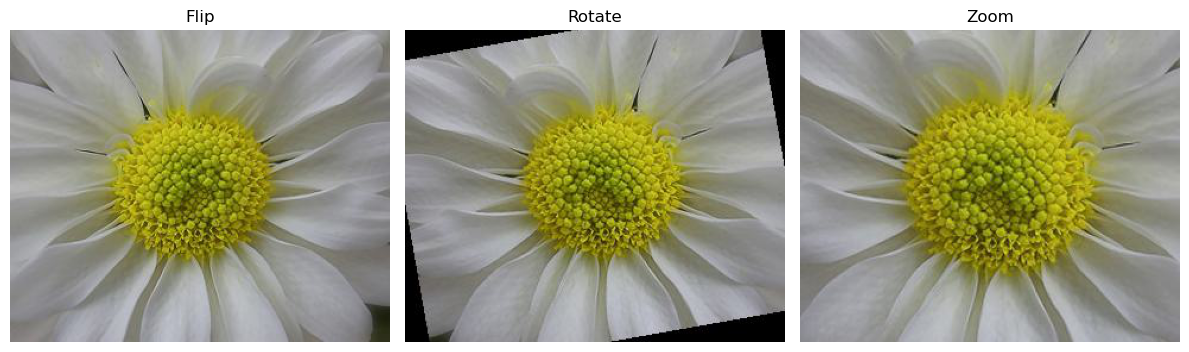

In [126]:
# Diretório base onde estão as pastas de treinamento
notebook_dir = pathlib.Path().resolve()

# Caminhos das pastas de cada transformação
treinamento_dirs = {
    "Flip": notebook_dir / "treinamento_flip" / "daisy",
    "Rotate": notebook_dir / "treinamento_rotate" / "daisy",
    "Zoom": notebook_dir / "treinamento_zoom" / "daisy"
}

# Criar a figura para plotar as imagens
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, (title, folder) in zip(axes, treinamento_dirs.items()):
    # Listar arquivos de imagem na pasta
    image_files = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    
    if image_files:  # Verifica se há imagens na pasta
        img_path = folder / image_files[0]  # Pega a primeira imagem
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(title)
        ax.axis("off")  # Remove os eixos
    else:
        ax.set_title(f"{title} (Nenhuma imagem encontrada)")
        ax.axis("off")

plt.tight_layout()
plt.show()


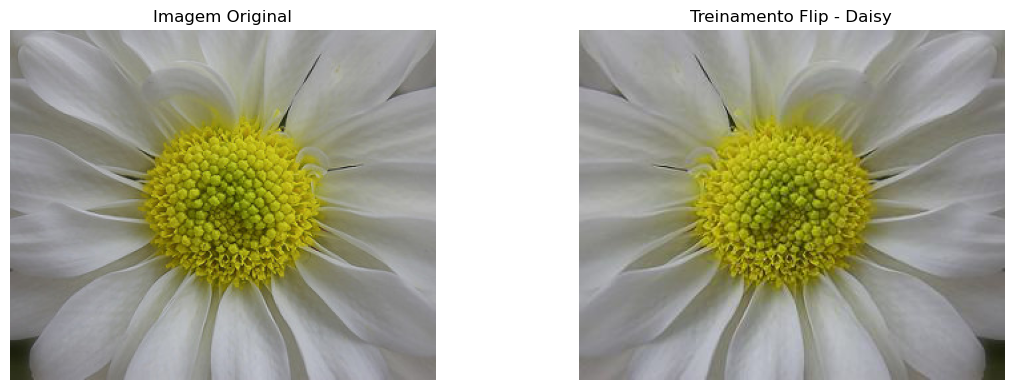

In [105]:
# Diretório base onde estão as pastas de treinamento
notebook_dir = pathlib.Path().resolve()

# Caminhos das imagens a serem exibidas
image_paths = {
    "Imagem Original": notebook_dir / "flower_photos" / "daisy",
    "Treinamento Flip - Daisy": notebook_dir / "treinamento_flip" / "daisy"   
}

# Criar a figura para exibir as imagens
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, (title, folder) in zip(axes, image_paths.items()):
    # Listar arquivos de imagem na pasta
    image_files = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    
    if image_files:  # Verifica se há imagens na pasta
        img_path = folder / image_files[0]  # Pega a primeira imagem
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(title)
        ax.axis("off")  # Remove os eixos
    else:
        ax.set_title(f"{title} (Nenhuma imagem encontrada)")
        ax.axis("off")

plt.tight_layout()
plt.show()

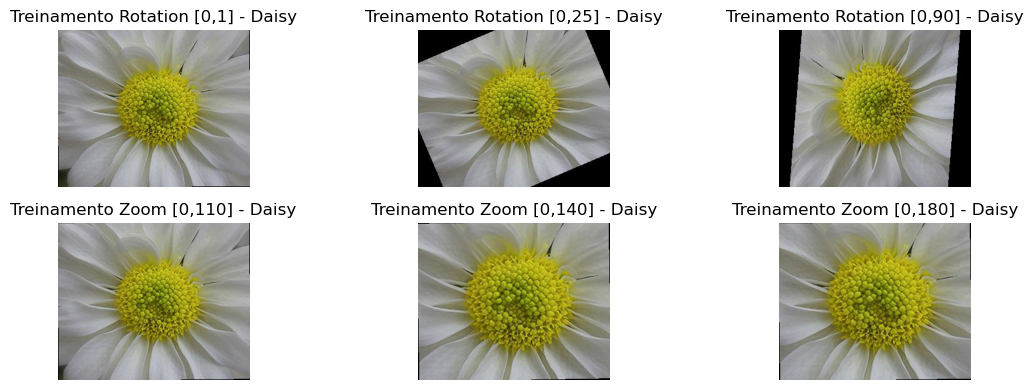

In [117]:
# Diretório base onde estão as pastas de treinamento
notebook_dir = pathlib.Path().resolve()

# Caminhos das imagens a serem exibidas
image_paths = {
    "Treinamento Rotation [0,1] - Daisy": notebook_dir / "treinamento_rotate_1" / "daisy",
    "Treinamento Rotation [0,25] - Daisy": notebook_dir / "treinamento_rotate_25" / "daisy",
    "Treinamento Rotation [0,90] - Daisy": notebook_dir / "treinamento_rotate_90" / "daisy",  
    "Treinamento Zoom [0,110] - Daisy": notebook_dir / "treinamento_zoom_110" / "daisy", 
    "Treinamento Zoom [0,140] - Daisy": notebook_dir / "treinamento_zoom_140" / "daisy", 
    "Treinamento Zoom [0,180] - Daisy": notebook_dir / "treinamento_zoom_180" / "daisy"
}

# Criar a figura para exibir as imagens
fig, axes = plt.subplots(2, 3, figsize=(12, 4))


for ax, (title, folder) in zip(axes.flatten(), image_paths.items()):
    # Listar arquivos de imagem na pasta
    image_files = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    
    if image_files:  # Verifica se há imagens na pasta
        img_path = folder / image_files[0]  # Pega a primeira imagem
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(title)
        ax.axis("off")  # Remove os eixos
    else:
        ax.set_title(f"{title} (Nenhuma imagem encontrada)")
        ax.axis("off")

plt.tight_layout()
plt.show()